# Stastic Arbitrage for Trading Analysis

<a href="https://www.kaggle.com/code/addarm/efficient-frontier-quant" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![TODO]()

## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance

You'll need access to [analysis_utils](./analysis_utils.py) library for common functions.

In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_prices_ts_df, plot_strategy, load_ticker_ts_df

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Running Local...


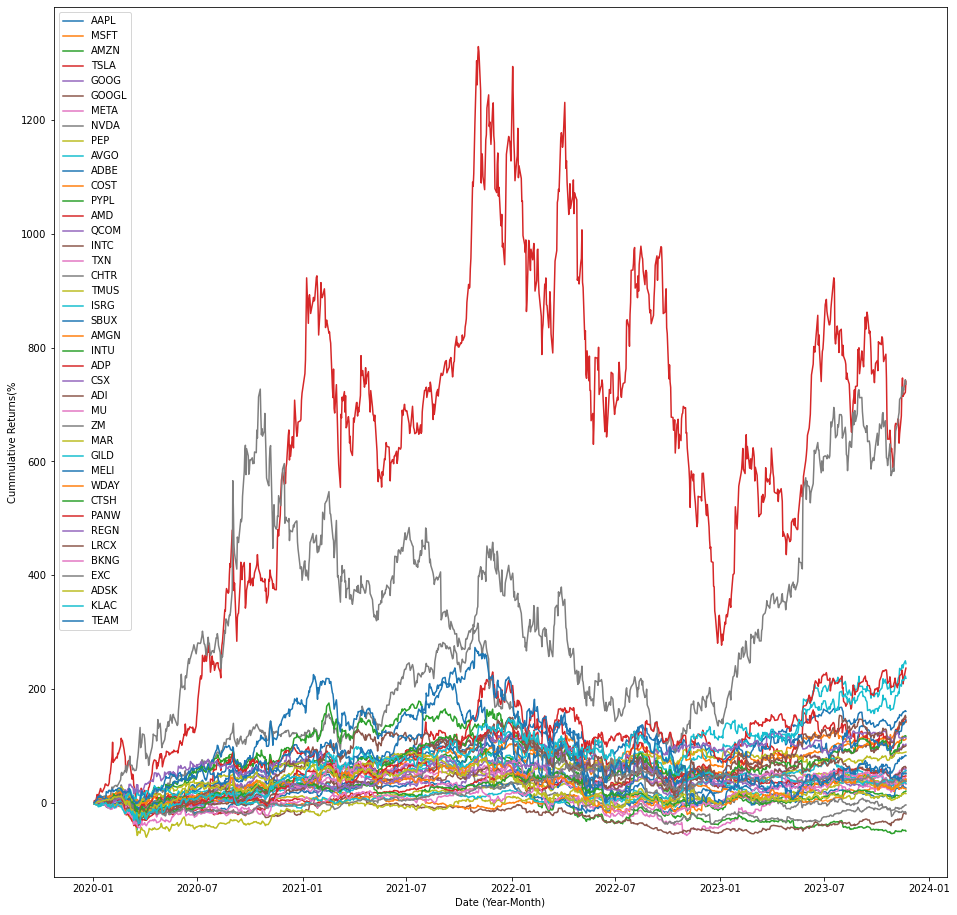

In [14]:
START_DATE = "2020-01-01"
END_DATE = "2023-11-22"

tickers = [
    "AAPL",
    "MSFT",
    "AMZN",
    "TSLA",
    "GOOG",
    "GOOGL",
    "META",
    "NVDA",
    "PEP",
    "AVGO",
    "ADBE",
    "COST",
    "PYPL",
    "AMD",
    "QCOM",
    "INTC",
    "TXN",
    "CHTR",
    "TMUS",
    "ISRG",
    "SBUX",
    "AMGN",
    "INTU",
    "ADP",
    "CSX",
    "ADI",
    "MU",
    "ZM",
    "MAR",
    "GILD",
    "MELI",
    "WDAY",
    "CTSH",
    "PANW",
    "REGN",
    "LRCX",
    "BKNG",
    "EXC",
    "ADSK",
    "KLAC",
    "TEAM",
]
tickers_df = load_ticker_prices_ts_df(tickers, START_DATE, END_DATE)
tickers_rets_df = tickers_df.dropna(axis=1).pct_change().dropna()  # first % is NaN

# 1+ to allow the cumulative product of returns over time, and -1 to remove it at the end.
tickers_rets_df = (1 + tickers_rets_df).cumprod() - 1

plt.figure(figsize=(16, 16))
for ticker in tickers_rets_df.columns:
    plt.plot(tickers_rets_df.index, tickers_rets_df[ticker] * 100.0, label=ticker)

plt.xlabel("Date (Year-Month)")
plt.ylabel("Cummulative Returns(%")
plt.legend()
plt.show()

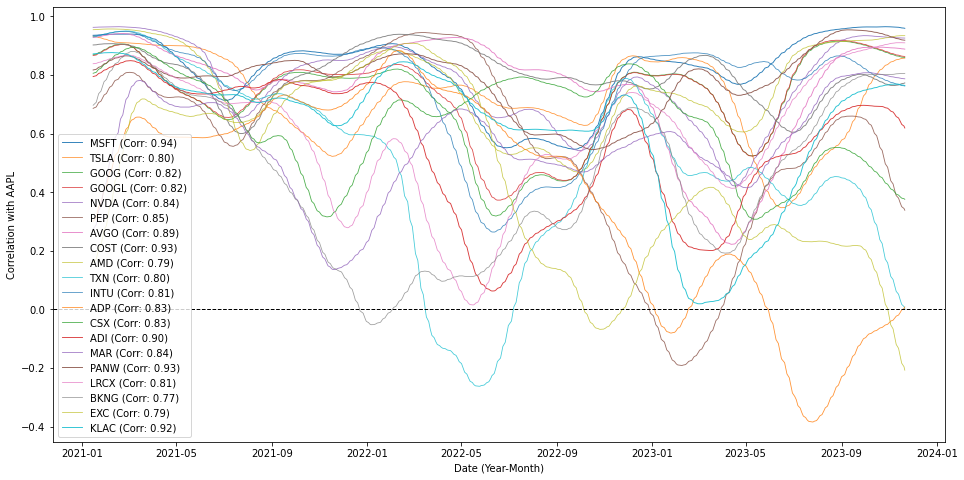

In [15]:
TARGET = "AAPL"
MA_WINDOW = 24
ARB_WINDOW = MA_WINDOW * 10
plt.figure(figsize=(16, 8))

corr_ticks = []
LEADS = []

for ticker in tickers:
    if ticker == TARGET:
        continue
    correlation = tickers_df[ticker].corr(tickers_df[TARGET])
    if abs(correlation) < 0.75:
        continue

    LEADS.append(ticker)

    corr_ts = tickers_df[ticker].rolling(ARB_WINDOW).corr(tickers_df[TARGET])
    plt.plot(
        tickers_df.index,
        corr_ts.rolling(MA_WINDOW).mean(),
        label=f"{ticker} (Corr: {correlation:.2f})",
        alpha=correlation,
        linewidth=correlation,
    )
    corr_ticks.append(ticker)

plt.axhline(y=0, color="k", linestyle="--", linewidth=1)

plt.xlabel("Date (Year-Month)")
plt.ylabel("Correlation with AAPL")
plt.legend()
plt.show()

The magnitude of the covariance may be more aligned with the desired/appropriate portfolio weights than correlation. Correlation ranges from -1 to 1 by definition, while covariance is unbounded.

Good question! Let me explain the covariance calculation here in a bit more detail:

The formula for covariance between two variables X and Y is:

Cov(X,Y) = Σ((X - μX) * (Y - μY)) / N

Where:

μX is the mean of X  
μY is the mean of Y
N is the number of observations

Applying this to our ice cream and drowning example:

- Mean ice cream sales (μX) = $200  
- Mean drowning deaths (μY) = 20
- N (number of months) = 5

Plugging this into our sum of products and dividing by N:

Cov(ice cream sales, drowning deaths) = Σ(X-200)(Y-20) / 5 
                                        = 50

So here, the covariance value of 50 represents the sum of products of the deviation from the mean for each variable over the sample. 

While 50 doesn't have an inherent exact interpretation, the sign positive sign indicates the variables move in the same direction, while the magnitude represents the level of co-movement. 

A higher positive covariance means that when one variable increases, the other tends to increase meaningfully too. So the magnitude measures the tendency of the variables to vary together.

Let me know if this helps explain what that covariance value of 50 represents!

delta positive => signal says TRADING_INSTRUMENT price should have moved up more than what it did
delta negative => signal says TRADING_INSTRUMENT price should have moved down more than what it did.

In [16]:
arb_df = tickers_rets_df.copy()
arb_df["price"] = tickers_df[TARGET]


arb_df[f"ema_{TARGET}"] = arb_df[TARGET].ewm(MA_WINDOW).mean()


arb_df[f"ema_d_{TARGET}"] = arb_df[TARGET] - arb_df[f"ema_{TARGET}"]


arb_df[f"ema_d_{TARGET}"].fillna(0, inplace=True)



for ticker in LEADS:
    arb_df[f"ema_{ticker}"] = arb_df[ticker].ewm(MA_WINDOW).mean()

    arb_df[f"ema_d_{ticker}"] = arb_df[ticker] - arb_df[f"ema_{ticker}"]

    arb_df[f"ema_d_{ticker}"].fillna(0, inplace=True)

    arb_df[f"{ticker}_corr"] = (
        arb_df[f"ema_d_{ticker}"].rolling(ARB_WINDOW).corr(arb_df[f"ema_d_{TARGET}"])
    )

    arb_df[f"{ticker}_covr"] = (
        arb_df[[f"ema_d_{ticker}", f"ema_d_{TARGET}"]]
        .rolling(ARB_WINDOW)
        .cov(numeric_only=True)
        .groupby(level=0, axis=0, dropna=True)  # Cov returns pairwise!
        .apply(lambda x: x.iloc[0, 1] / x.iloc[0, 0])
    )


    arb_df[f"{ticker}_emas_d_prj"] = (
        arb_df[f"ema_d_{ticker}"] * arb_df[f"{ticker}_covr"]
    )


    arb_df[f"{ticker}_emas_act"] = (
        arb_df[f"{ticker}_emas_d_prj"] - arb_df[f"ema_d_{TARGET}"]
    )



arb_df.filter(regex=f"(_emas_d_prj|_corr|_covr)$").dropna().iloc[ARB_WINDOW:]

,MSFT_corr,MSFT_covr,MSFT_emas_d_prj,TSLA_corr,TSLA_covr,TSLA_emas_d_prj,GOOG_corr,GOOG_covr,GOOG_emas_d_prj,GOOGL_corr,...,LRCX_emas_d_prj,BKNG_corr,BKNG_covr,BKNG_emas_d_prj,EXC_corr,EXC_covr,EXC_emas_d_prj,KLAC_corr,KLAC_covr,KLAC_emas_d_prj
2021-11-26,0.612580,0.839504,0.055616,0.472719,0.032754,0.038246,0.308343,0.435160,-0.008875,0.330477,...,0.012525,-0.327754,-0.504663,0.059283,0.269704,0.686468,0.027165,0.230976,0.156145,0.019248
2021-11-29,0.621705,0.853348,0.090395,0.473388,0.032766,0.056861,0.306532,0.432054,0.011609,0.328948,...,0.024105,-0.340046,-0.517941,0.052070,0.271312,0.689753,0.037782,0.232781,0.157110,0.031252
2021-11-30,0.620469,0.856732,0.055605,0.475950,0.033068,0.057955,0.289995,0.407889,-0.010452,0.312419,...,0.023839,-0.360289,-0.541777,0.072384,0.266614,0.681344,0.013571,0.234827,0.159258,0.025488
2021-12-01,0.619945,0.859497,0.050884,0.474247,0.033109,0.037327,0.275748,0.386039,-0.014018,0.298249,...,0.028469,-0.379256,-0.561148,0.081020,0.259410,0.664738,0.006075,0.237797,0.161654,0.028382
2021-12-02,0.618596,0.861111,0.045845,0.472821,0.033226,0.032106,0.268183,0.375892,-0.001710,0.290235,...,0.016754,-0.389908,-0.574244,0.051714,0.256866,0.660360,0.015232,0.237542,0.162053,0.018846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-15,0.806229,1.040377,0.202470,0.707421,0.074712,0.025069,0.519042,0.663467,0.032854,0.529691,...,0.128505,0.125326,0.228964,0.015971,-0.148216,-0.378400,-0.006200,0.248233,0.201460,0.069955
2023-11-16,0.806942,1.034919,0.235074,0.705455,0.074714,0.000937,0.519152,0.664720,0.053254,0.529491,...,0.128923,0.127478,0.233437,0.016499,-0.145621,-0.374551,-0.003472,0.256638,0.207711,0.069229
2023-11-17,0.807774,1.033376,0.184828,0.703689,0.074804,0.002678,0.517832,0.664099,0.034664,0.527947,...,0.123776,0.129268,0.237005,0.016783,-0.143577,-0.372271,0.003397,0.264640,0.213599,0.067335
2023-11-20,0.808248,1.028097,0.224927,0.700523,0.074703,0.005818,0.515529,0.662413,0.042308,0.525439,...,0.157443,0.131812,0.241685,0.018967,-0.135353,-0.356388,0.001547,0.275481,0.220496,0.082902


In [17]:
weights = 0
delta_projected = 0
for ticker in LEADS:
    corr_abs = abs(arb_df[f"{ticker}_corr"].fillna(0))
    weights += corr_abs
    arb_df[f"{ticker}_emas_act_w"] = arb_df[f"{ticker}_emas_act"].fillna(0) * corr_abs
    delta_projected += arb_df[f"{ticker}_emas_act_w"]

weights = weights.replace(0, 1)
weights.dropna().iloc[ARB_WINDOW:]

2020-12-15    12.556093
2020-12-16    12.557298
2020-12-17    12.559122
2020-12-18    12.540434
2020-12-21    12.535081
                ...    
2023-11-15     9.278102
2023-11-16     9.314386
2023-11-17     9.346886
2023-11-20     9.379587
2023-11-21     9.398846
Name: MSFT_corr, Length: 739, dtype: float64

In [18]:
arb_df[f"{TARGET}_signal"] = delta_projected / weights
arb_df[f"{TARGET}_signal"].iloc[ARB_WINDOW:]

2020-12-15   -0.060067
2020-12-16   -0.054206
2020-12-17   -0.055738
2020-12-18   -0.022273
2020-12-21   -0.050730
                ...   
2023-11-15   -0.056379
2023-11-16   -0.078522
2023-11-17   -0.074022
2023-11-20   -0.073613
2023-11-21   -0.065105
Name: AAPL_signal, Length: 739, dtype: float64

If we’re working with larger samples (n≥30), we can assume that the sampling distribution of the sample mean is normally distributed (thanks to the Central Limit Theorem) and can instead use the norm.interval() function from the scipy.stats library.

In [19]:
errors = (
    arb_df[f"ema_{TARGET}"] + arb_df[f"ema_d_{TARGET}"] + arb_df[f"{TARGET}_signal"]
) - (arb_df[f"ema_{TARGET}"].shift(-1))
arb_df["rmse"] = np.sqrt((errors**2).rolling(ARB_WINDOW).mean()).fillna(0)

me = errors.rolling(ARB_WINDOW).mean().fillna(0)
e_std = errors.rolling(ARB_WINDOW).std().fillna(0)
ci = (me - 1.96 * e_std, me + 1.96 * e_std)

arb_df["ci_lower"] = arb_df[f"{TARGET}_signal"].fillna(0) + ci[0]
arb_df["ci_upper"] = arb_df[f"{TARGET}_signal"].fillna(0) + ci[1]

arb_df.fillna(0, inplace=True)
arb_df[["ci_lower", "ci_upper"]].iloc[ARB_WINDOW:]

,ci_lower,ci_upper
2020-12-15,-0.190854,0.179737
2020-12-16,-0.184644,0.185730
2020-12-17,-0.185726,0.184355
2020-12-18,-0.151886,0.217988
2020-12-21,-0.180143,0.189625
...,...,...
2023-11-15,-0.095494,0.046968
2023-11-16,-0.117655,0.024896
2023-11-17,-0.113162,0.029605
2023-11-20,-0.112755,0.030541


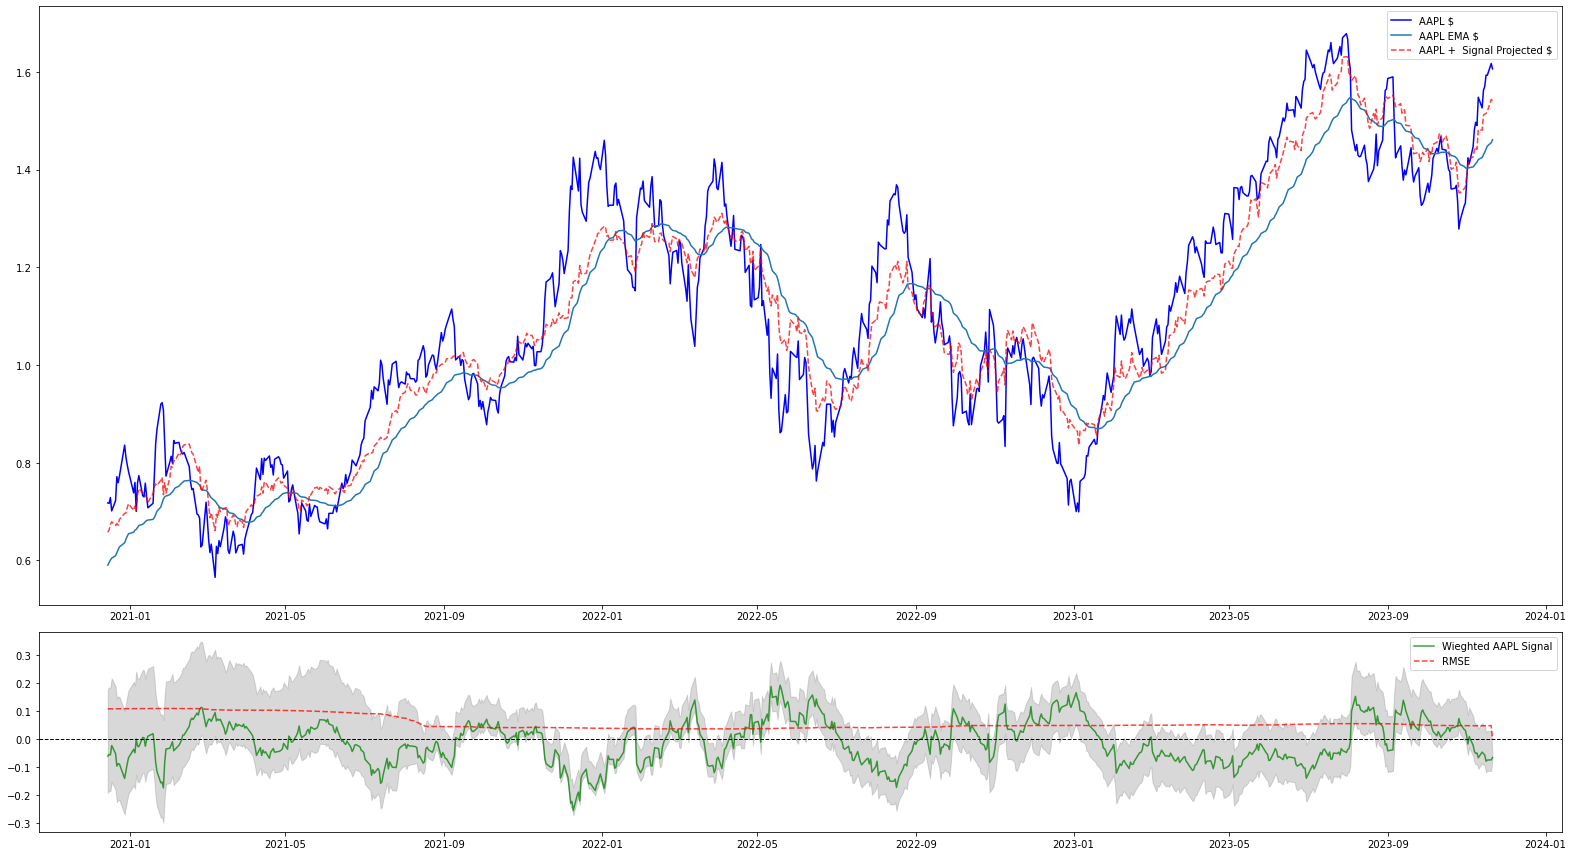

In [20]:
fig, axes = plt.subplots(2, 1, gridspec_kw={"height_ratios": (3, 1)}, figsize=(22, 12))

axes[0].plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df["AAPL"].iloc[ARB_WINDOW:],
    label="AAPL $",
    alpha=1,
    color="b",
)
axes[0].plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df["ema_AAPL"].iloc[ARB_WINDOW:],
    label="AAPL EMA $",
    alpha=1,
)
axes[0].plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df[f"{TARGET}_signal"].iloc[ARB_WINDOW:].fillna(0)
    + arb_df["AAPL"].iloc[ARB_WINDOW:],
    label="AAPL +  Signal Projected $",
    alpha=0.75,
    linestyle="--",
    color="r",
)
axes[0].legend()

axes[1].plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df[f"{TARGET}_signal"].iloc[ARB_WINDOW:],
    label="Wieghted AAPL Signal",
    alpha=0.75,
    color="g",
)
axes[1].plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df["rmse"].iloc[ARB_WINDOW:],
    label="RMSE",
    alpha=0.75,
    linestyle="--",
    color="r",
)
axes[1].fill_between(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df["ci_lower"].iloc[ARB_WINDOW:],
    arb_df["ci_upper"].iloc[ARB_WINDOW:],
    color="gray",
    alpha=0.3,
)
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].legend()

plt.tight_layout()
plt.show()

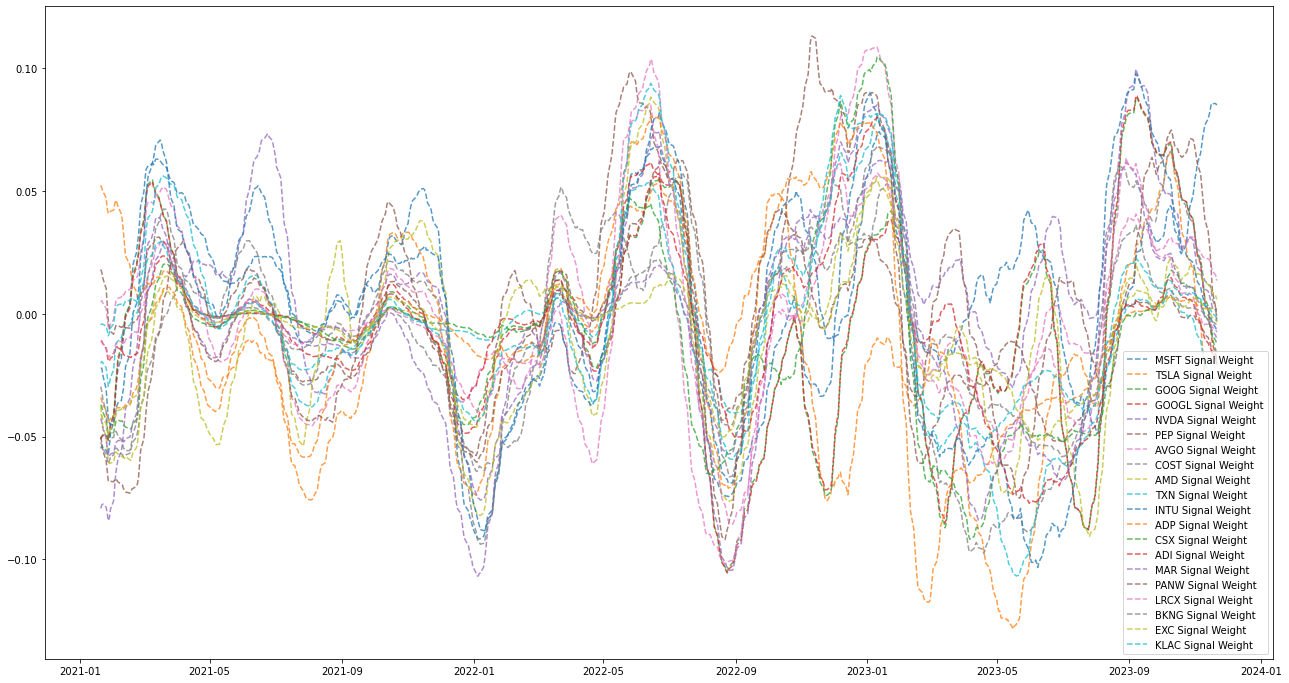

In [21]:
plt.figure(figsize=(22, 12))

for ticker in LEADS:
    plt.plot(
        arb_df.iloc[ARB_WINDOW:].index,
        arb_df[f"{ticker}_emas_act_w"].iloc[ARB_WINDOW:].rolling(MA_WINDOW).mean(),
        label=f"{ticker} Signal Weight",
        alpha=0.75,
        linestyle="--",
    )

plt.legend()
plt.show()

In [22]:
LONG_THRESHOLD = 0.05
SHORT_THRESHOLD = -0.05

MAX_SHARES = 1

arb_df["orders"] = 0
signals = arb_df[f"{TARGET}_signal"]
prev_signals = signals.shift(-1)

add_long_cond = (signals > LONG_THRESHOLD) & (prev_signals <= LONG_THRESHOLD)
add_short_cond = (signals < SHORT_THRESHOLD) & (prev_signals >= SHORT_THRESHOLD)

arb_df.loc[add_long_cond, "orders"] += MAX_SHARES
arb_df.loc[add_short_cond, "orders"] -= MAX_SHARES

arb_df["orders"].fillna(0, inplace=True)
arb_df.loc[arb_df["orders"] != 0, "orders"]

2020-12-17   -1
2020-12-31   -1
2021-01-28   -1
2021-02-26    1
2021-03-12    1
             ..
2023-09-21    1
2023-10-04    1
2023-10-27    1
2023-11-08   -1
2023-11-10   -1
Name: orders, Length: 65, dtype: int64

In [23]:
arb_df["pnl"] = 0.0
arb_df["holdings"] = 0.0

orders = arb_df["orders"]
current_signal = signals
prev_signal = signals.shift(1)

pnl_close = arb_df["holdings"].shift(1).values * prev_signal
pnl_open = orders * current_signal

arb_df["holdings"] = arb_df["holdings"].shift(1) + orders.cumsum()
arb_df["pnl"] = (pnl_close * arb_df["price"]) + (pnl_open * arb_df["price"])
arb_df["pnl"] = arb_df["pnl"].cumsum()

arb_df.loc[arb_df["holdings"] != 0, ["pnl", "holdings", f"{TARGET}_signal"]]

,pnl,holdings,AAPL_signal
2020-01-03,NaN,NaN,0.000000
2020-12-17,7.048989,-1.0,-0.055738
2020-12-18,7.048989,-1.0,-0.022273
2020-12-21,7.048989,-1.0,-0.050730
2020-12-22,7.048989,-1.0,-0.095826
...,...,...,...
2023-11-15,638.411841,-7.0,-0.056379
2023-11-16,638.411841,-7.0,-0.078522
2023-11-17,638.411841,-7.0,-0.074022
2023-11-20,638.411841,-7.0,-0.073613


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1872x1296 with 0 Axes>

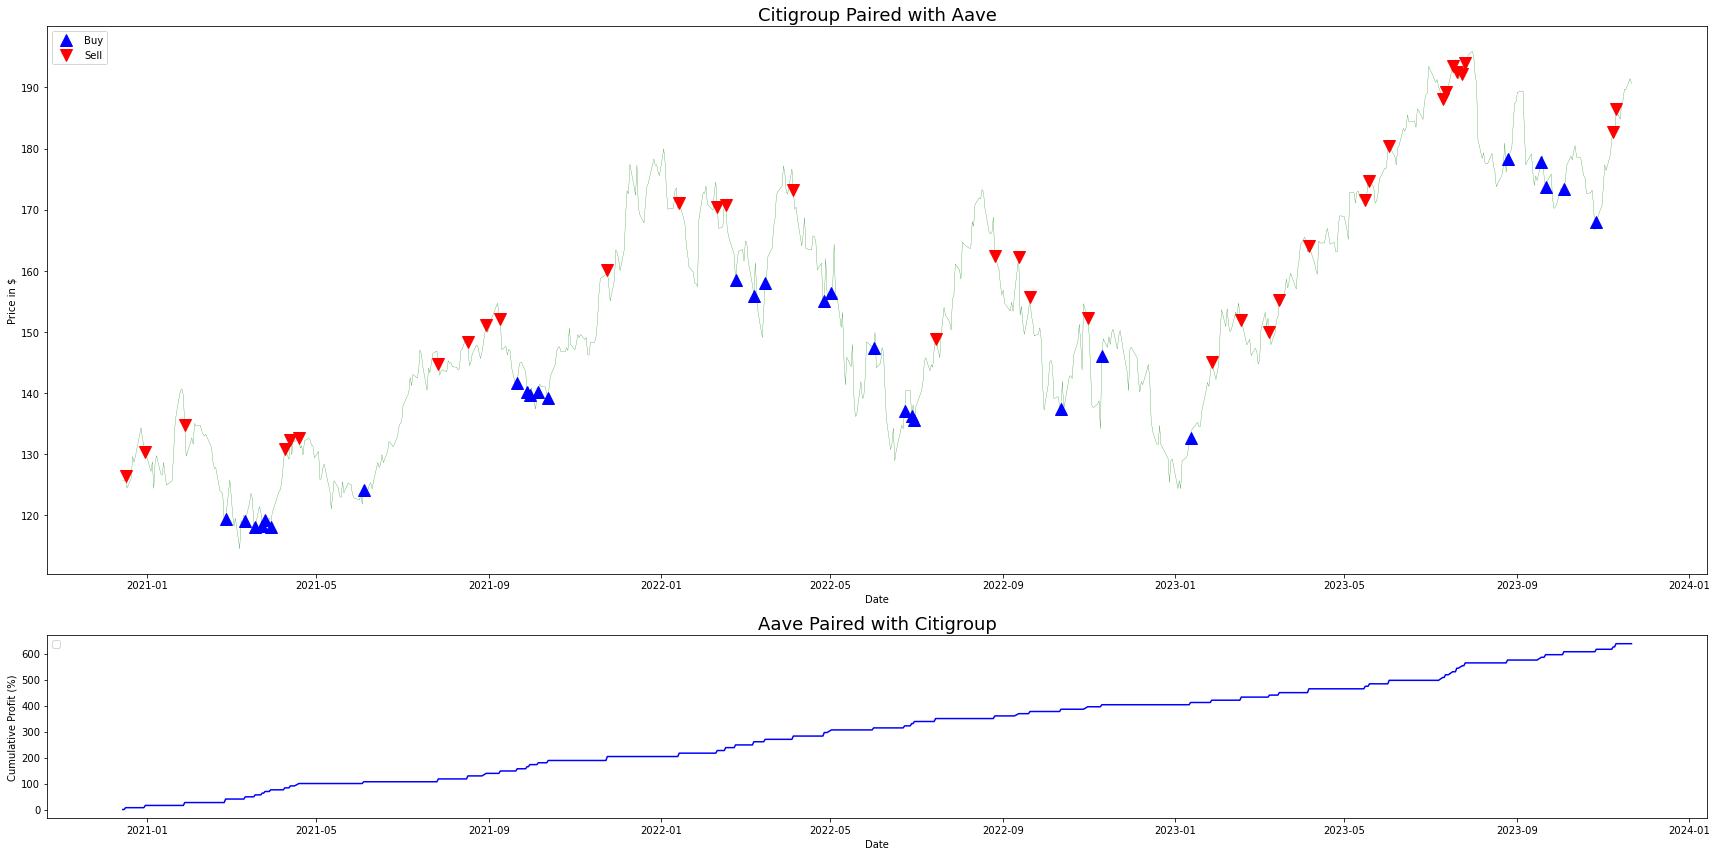

In [25]:
plt.figure(figsize=(26, 18))

fig, (ax1, ax2) = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": (3, 1)}, figsize=(24, 12)
)

ax1.set_xlabel("Date")
ax1.set_ylabel("Price in $")
ax1.plot(
    arb_df.iloc[ARB_WINDOW:].index,
    arb_df["price"].iloc[ARB_WINDOW:],
    color="g",
    lw=0.25,
)

# Plot the Buy and Sell signals
ax1.plot(
    arb_df.loc[add_long_cond].index,
    arb_df.loc[add_long_cond, "price"],
    "^",
    markersize=12,
    color="blue",
    label="Buy",
)
ax1.plot(
    arb_df.loc[add_short_cond].index,
    arb_df.loc[add_short_cond, "price"],
    "v",
    markersize=12,
    color="red",
    label="Sell",
)
ax2.plot(
    arb_df["pnl"].iloc[ARB_WINDOW:].index, arb_df["pnl"].iloc[ARB_WINDOW:], color="b"
)
ax2.set_ylabel("Cumulative Profit (%)")
ax2.set_xlabel("Date")

ax1.legend(loc="upper left", fontsize=10)
ax1.set_title(f"Citigroup Paired with Aave", fontsize=18)
ax2.legend(loc="upper left", fontsize=10)
ax2.set_title(f"Aave Paired with Citigroup", fontsize=18)

plt.tight_layout()
plt.show()

# Conclusion

TODO

![TODO]()

## References

- https://www.nasdaq.com/solutions/nasdaq-100/companies
- 
## Github

Article here is also available on [Github]()

Kaggle notebook available [here]()


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.